In [1]:
import sys
import os
import time
import json
import numpy as np
from scipy.stats import pearsonr, spearmanr, kendalltau
from scipy.spatial import ConvexHull
from scipy.spatial.qhull import QhullError
import pandas as pd
from operator import itemgetter
from itertools import chain
from collections import Counter
from tqdm.notebook import tqdm
from ipywidgets import interact
from plotly.offline import init_notebook_mode, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize

import string
from nltk.corpus import stopwords
from transformers import BertTokenizer

import matplotlib.pyplot as plt

from bert_serving.client import BertClient

import torch
from torch.utils.tensorboard import SummaryWriter

from config import *

In [2]:
INVALID_TOKENS = set(stopwords.words('english') + list(string.punctuation))
TOKENIZER = BertTokenizer.from_pretrained('bert-base-uncased')

## Extractive Summarization by Maximizing Semantic Volume

Paper: https://www.aclweb.org/anthology/D15-1228.pdf

In [3]:
def max_semantic_volume_summary(R, L, dist):
    '''Implementation of the "Extractive Summarization by Maximizing Semantic Volume".
    
    :param R: Sentence reprezentations
    :type R: np.array
    
    :param L: Number of sentences in summary
    :type L: int
    
    :param dist: Function that computes distance to subspace
    :type dist: func
    
    :return: Sentence indices
    :rtype: list
    '''
    def mask(N, idx):
        mask = np.ones(N, dtype=bool)
        mask[idx] = False
        return mask

    N = R.shape[0]

    B = np.ndarray(shape=(0,R.shape[1]))
    idx = []

    c = R.sum(axis=0) / N

    p = np.argmax(np.linalg.norm(R - c, axis=1))
    idx.append(p)

    q = np.argmax(np.linalg.norm(R - R[p], axis=1))
    idx.append(q)

    b_0 = R[q] / np.linalg.norm(R[q])
    B = np.append(B, b_0.reshape(1,-1), axis=0)

    for i in range(L-2):
        r = np.argmax(np.apply_along_axis(dist, 1, R[mask(N, idx)], B))
        if r not in idx:
            idx.append(r)

            b_r = R[r] / np.linalg.norm(R[r])
            B = np.append(B, b_r.reshape(1,-1), axis=0)
        
    return idx

### Misc

In [4]:
def load_data(dataset, encoded):
    with open(os.path.join(DATA_DIR, dataset + ('_encoded.json' if encoded else '.json')), mode='r') as fp:
        return json.load(fp)
    
def extract(topic):
    documents = list(chain(*topic['documents']))
    annotations = topic['annotations']

    summaries = list(map(itemgetter('text'), annotations))
    pyr_scores = list(map(itemgetter('pyr_score'), annotations))
    
    return documents, summaries, pyr_scores

### Visualization

In [5]:
def make_pytorch_projector(log_dir, mat, labels=None):
    '''Exports PyTorch projector'''
    writer = SummaryWriter(log_dir)
    writer.add_embedding(mat, metadata=labels)
    writer.close()

def project_pca(document_embs, summary_embs):
    pca = PCA(n_components=2)
    document_pts = pca.fit_transform(document_embs)
    summary_pts = list(map(pca.transform, summary_embs))
    return document_pts, summary_pts

def project_tsne(document_embs, summary_embs):
    n = np.cumsum([0] + list(map(len,summary_embs)))
    embs = document_embs + list(chain(*summary_embs))
    tsne = TSNE(n_iter=3000, perplexity=30, verbose=1)
    pts = tsne.fit_transform(embs)
    return pts[:len(document_embs)], [pts[i:j] for i,j in zip(n[:-1], n[1:])]

def plt_hull(ax, pts, c):
    hull = ConvexHull(pts)
    idx = np.concatenate((hull.vertices, hull.vertices[:1]))
    ax.plot(pts[idx,0], pts[idx,1], f'{c}--', lw=2)
    
def plot(ax, document_pts, summary_pts, add_hull=True):
    ax.scatter(document_pts[:,0], document_pts[:,1], c='b', alpha=0.25 if add_hull else 1)
    ax.scatter(summary_pts[:,0], summary_pts[:,1], c='r', alpha=0.25 if add_hull else 1)
    if add_hull:
        plt_hull(ax, document_pts, 'b')
        plt_hull(ax, summary_pts, 'r')

### Preprocessing

In [6]:
def valid_tokens(sentence):
    '''Outputs valid tokens in a sentence.
    
    Input:  list of tokens
    Output: list of valid tokens
    '''
    return list(filter(lambda token: token not in INVALID_TOKENS, sentence))

def tokenize_document(document):
    '''Tokenizes every sentence in a document.
    
    Input:  list of str
    Output: list of list of tokens
    '''
    return list(map(TOKENIZER.tokenize, document))

def filter_document(document):
    '''Filters every sentence in a document (extract valid tokens).
    
    Input:  list of list of tokens
    Output: list of list of valid tokens
    '''
    return list(map(valid_tokens, document))

def preprocess(document):
    '''Preprocesses a list of sentences.
    
    Input:  list of str
    Output: list of list of valid tokens
    '''
    return filter_document(tokenize_document(document))

### Metrics

In [7]:
def number_of_repeating_words(summary):
    '''Counts the number of repeating words in a summary'''
    cnt = Counter(chain(*preprocess(summary)))
    return len([cnt[k] for k in cnt if cnt[k] > 1])

def distance_to_subspace(v, S):
    '''Calculates a distance from vector to subspace'''
    return np.linalg.norm(v - (v @ S.T) @ S)

def average_distance_between_vectors(S):
    '''Calculates the average distance between vectors'''
    return np.mean([np.mean(np.linalg.norm(si - S, axis=1)) for si in S])

def naive(documents, summaries):
    scores = []
    for summary in summaries:
        scores.append(number_of_repeating_words(summary))
    return np.array(scores)

def average_distance(document_embs, summary_embs):
    scores = []
    for summary in summary_embs:
        S = np.array(summary)
        scores.append(average_distance_between_vectors(S))
    return np.array(scores)

def semantic_volume(document_embs, summary_embs, normalize=False):
    scores = []
    document_hull = ConvexHull(document_embs)
    for summary in summary_embs:
        try:
            summary_hull = ConvexHull(summary)
            scores.append(summary_hull.volume / (document_hull.volume if normalize else 1))
        except QhullError: # Not enough points
            scores.append(0)
    return np.array(scores)

# Introduction

Use-case:
1. Take the documents, summaries, and pyramid scores
2. Embed the documents and summaries (or load embeddings)
3. Calculate score for summaries
4. Compute correlation with human judgements
5. Plot

In [8]:
DATASET = DATASETS[0]
TOPIC = 'D0841'

# Scores

In [9]:
def remove_empty(summary_embs, pyr_scores):
    idx = np.nonzero(list(map(len, summary_embs)))[0]
    return np.array(summary_embs)[idx].tolist(), np.array(pyr_scores)[idx].tolist()

def execute(tac, experiment):
    scores = []

    for topic_id, topic in tac.items():
        document_embs, summary_embs, pyr_scores = extract(topic)
        
        summary_embs, pyr_scores = remove_empty(summary_embs, pyr_scores)
        
        try:
            scores.append(experiment(document_embs, summary_embs, pyr_scores))
        except Exception as e:
            print(f'=== {topic_id} ===')
            print(e, '\n')
    
    return scores

In [10]:
def experiment_average_distance(document_embs, summary_embs, pyr_scores):
    naive_scores = average_distance(document_embs, summary_embs)
    return kendalltau(pyr_scores, naive_scores)[0]

def experiment_semantic_volume(document_embs, summary_embs, pyr_scores):
    document_pts, summary_pts = project_pca(document_embs, summary_embs)
    semantic_volume_scores = semantic_volume(document_pts, summary_pts)
    return kendalltau(pyr_scores, semantic_volume_scores)[0]

def experiment_semantic_volume_norm(document_embs, summary_embs, pyr_scores):
    document_pts, summary_pts = project_pca(document_embs, summary_embs)
    semantic_volume_scores = semantic_volume(document_pts, summary_pts, normalize=True)
    return kendalltau(pyr_scores, semantic_volume_scores)[0]

In [11]:
tac = load_data(DATASET, encoded=True)

In [12]:
print('=== Experiments ===\n')
s = ''

print('   Executing "Average distance"')
scores = execute(tac, experiment_average_distance)
s += f'   Average distance:          {np.mean(scores):.6f}\n'

print('   Executing "Semantic volume"')
scores = execute(tac, experiment_semantic_volume)
s += f'   Semantic volume:           {np.mean(scores):.6f}\n'

print('   Executing "Semantic volume (norm)"')
scores = execute(tac, experiment_semantic_volume_norm)
s += f'   Semantic volume (norm):    {np.mean(scores):.6f}\n'

print('\n=== Results ===\n')
print(s)

=== Experiments ===

   Executing "Average distance"
   Executing "Semantic volume"
   Executing "Semantic volume (norm)"

=== Results ===

   Average distance:          -0.015658
   Semantic volume:           0.014678
   Semantic volume (norm):    0.014677



# Plotting BERT

In [13]:
### Load
tac = load_data(DATASET, encoded=True)

### Extract
topic = tac[TOPIC]
document_embs, summary_embs, pyr_scores = extract(topic)

### Convert to numpy array for convinience
document_embs_np = np.array(document_embs)
summary_embs_np = np.array(summary_embs)
pyr_scores_np = np.array(pyr_scores)

### Get indices of sorted pyramid socres
m = np.argsort(-pyr_scores_np) # Holds sorted indices of the pyramid scores

## System summaries

### TensorBoard

Exports two projectors (both contain the document embeddings):
1. Embeddings of the summary with highest pyramid score
2. Embeddings of all summaries sorted by pyramid score

In [14]:
t = int(time.time())

data = torch.tensor(document_embs + summary_embs[m[0]])
labels = [0] * len(document_embs) + [1] * len(summary_embs[m[0]])
make_pytorch_projector(os.path.join(RUNS_DIR, f'geometry_sumarization_best_{t}'), data, labels)

data = torch.tensor(document_embs + list(chain(*[summary_embs[m[i]] for i in range(len(m))])))
labels = [0] * len(document_embs) + list(chain(*[[i+1] * len(summary_embs[m[i]]) for i in range(len(m))]))
make_pytorch_projector(os.path.join(RUNS_DIR, f'geometry_sumarization_all_{t}'), data, labels)

### PCA

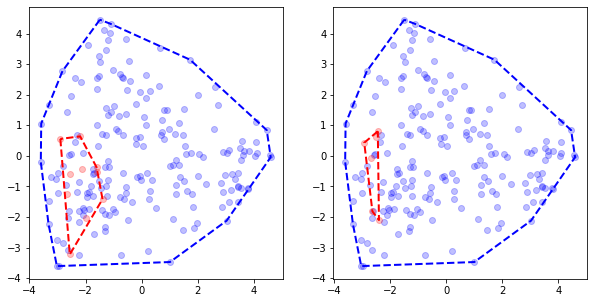

In [15]:
document_pts, summary_pts = project_pca(document_embs, summary_embs_np[m])

fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,2,1)
plot(ax1, document_pts, summary_pts[0], add_hull=True)

ax2 = fig.add_subplot(1,2,2)
plot(ax2, document_pts, summary_pts[1], add_hull=True)

### t-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 462 samples in 0.018s...
[t-SNE] Computed neighbors for 462 samples in 0.228s...
[t-SNE] Computed conditional probabilities for sample 462 / 462
[t-SNE] Mean sigma: 2.870281
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.962700
[t-SNE] KL divergence after 3000 iterations: 0.637848


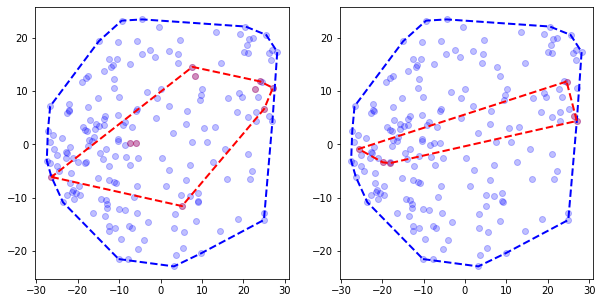

In [16]:
document_pts, summary_pts = project_tsne(document_embs, summary_embs_np[m])

fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,2,1)
plot(ax1, document_pts, summary_pts[0], add_hull=True)

ax2 = fig.add_subplot(1,2,2)
plot(ax2, document_pts, summary_pts[1], add_hull=True)

## Extractive Summarization by Maximizing Semantic Volume

### PCA

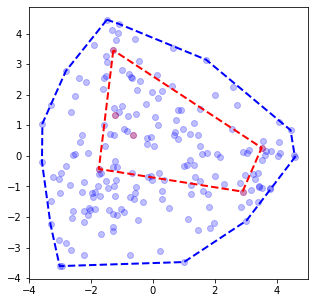

In [17]:
idx = max_semantic_volume_summary(document_embs_np, 6, distance_to_subspace)

document_pts, summary_pts = project_pca(document_embs, np.expand_dims(document_embs_np[idx], axis=0))

fig = plt.figure(figsize=(5,5))

ax1 = fig.add_subplot(1,1,1)
plot(ax1, document_pts, summary_pts[0], add_hull=True)

# Plotting SVD

In [18]:
### Load
tac = load_data(DATASET, encoded=False)

### Extract
topic = tac[TOPIC]
documents, summaries, pyr_scores = extract(topic)

### Convert to numpy array for convinience
pyr_scores_np = np.array(pyr_scores)

### Get indices of sorted pyramid socres
m = np.argsort(-pyr_scores_np) # Holds sorted indices of the pyramid scores

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

### Count bigrams
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2))
X = vectorizer.fit_transform(documents)

### Decompose
svd = TruncatedSVD(n_components=600, random_state=42)
svd.fit(X)

TruncatedSVD(algorithm='randomized', n_components=600, n_iter=5,
             random_state=42, tol=0.0)

In [20]:
document_embs = svd.transform(vectorizer.transform(documents))
summary_embs = np.expand_dims(svd.transform(vectorizer.transform(summaries[m[0]])), axis=0)

## System summaries

### PCA

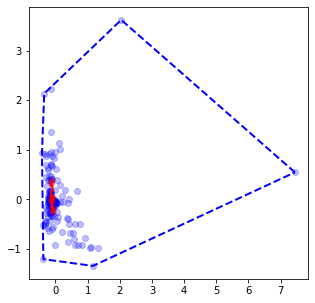

In [21]:
document_pts, summary_pts = project_pca(document_embs, summary_embs)

fig = plt.figure(figsize=(5,5))

ax1 = fig.add_subplot(1,1,1)
plot(ax1, document_pts, summary_pts[0], add_hull=True)

## Extractive Summarization by Maximizing Semantic Volume

###  PCA

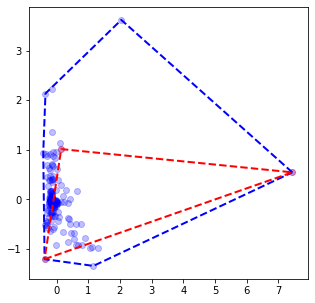

In [22]:
idx = max_semantic_volume_summary(document_embs, 6, distance_to_subspace)

document_pts, summary_pts = project_pca(document_embs, np.expand_dims(document_embs[idx], axis=0))

fig = plt.figure(figsize=(5,5))

ax1 = fig.add_subplot(1,1,1)
plot(ax1, document_pts, summary_pts[0], add_hull=True)

# Interactive plot BERT

In [23]:
### Load
tac = load_data(DATASET, encoded=True)

### Extract
topic = tac[TOPIC]
document_embs, summary_embs, pyr_scores = extract(topic)

### Convert to numpy array for convinience
document_embs_np = np.array(document_embs)
summary_embs_np = np.array(summary_embs)
pyr_scores_np = np.array(pyr_scores)

### Get indices of sorted pyramid socres
m = np.argsort(-pyr_scores_np) # Holds sorted indices of the pyramid scores

### Plotly + PCA

In [24]:
document_pts, summary_pts = project_pca(document_embs, summary_embs_np[m])

def make_df(pts, label):
    df = pd.DataFrame(pts, columns=['pca-0','pca-1'])
    df['label'] = label
    return df

df = pd.concat([make_df(document_pts, 'doc')] + \
               [make_df(summary_pts[i], f'sum-{i+1}') for i in range(len(summary_pts))], ignore_index=True)

In [25]:
@interact
def scatter_plot(label=df.label.unique()[1:]):
    df[df.label.isin(('doc',label))].iplot(kind='scatter',
                                           title=DATASET + ' - ' + TOPIC,
                                           x='pca-0',y='pca-1',
                                           mode='markers',
                                           categories='label',
                                           theme='solar',
                                           colorscale='set1')

interactive(children=(Dropdown(description='label', options=('sum-1', 'sum-2', 'sum-3', 'sum-4', 'sum-5', 'sum…